# Differential Privacy
The point of this notebook is to explore how we can introduce the concept of differential privacy to our dataset. This means adding statistical noise to sensitive data fields so it's harder to reverse engineer individuals to whom the data belongs. Local differential privacy is similar, it just specifies that we add this statisical noise right at the beginning when the data is being recorded.

Ultimately since the statistical noise is something like Laplace normal, or regular normal, the overall results don't change, but individuals remain secret. The amount of noise we add is based on the epsilon. 

For a binary class like Sex, the epsilon goes into the probability with which we flip the class. With Age, it's a simpler addition of Laplace noise.

In [42]:
import numpy as np
import pandas as pd
from aif360.datasets import AdultDataset

# load dataset
dataset = AdultDataset()
df = pd.DataFrame(dataset.features, columns=dataset.feature_names)
df['income'] = dataset.labels.ravel()

# DON'T binarize age
# age_median = df['age'].median()
# df['age_binary'] = (df['age'] > age_median).astype(int)
df['age'] = df['age'].astype(int)

# clean binary sex col as well
df['sex_binary'] = df['sex'].astype(int)
df[['age', 'sex_binary', 'income']].head(30)


,age,sex_binary,income
0,25,1,0.0
1,38,1,0.0
2,28,1,1.0
3,44,1,1.0
4,34,1,0.0
5,63,1,1.0
6,24,0,0.0
7,55,1,0.0
8,65,1,1.0
9,36,1,0.0


Now that we have binarized Age + Sex, we can have 4 such categories. So we can bucketise them.

In [43]:
# show sample of the dataset
df.sample(20)

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,...,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income,sex_binary
30711,40,13.0,1.0,1.0,7298.0,0.0,48.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
40819,84,4.0,0.0,1.0,0.0,0.0,10.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
24170,40,9.0,0.0,0.0,0.0,0.0,35.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
41509,47,14.0,1.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
40553,26,3.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
42603,30,9.0,1.0,0.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
12698,37,10.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
37678,29,13.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
35358,36,15.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
18544,19,10.0,1.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [44]:
# buckets: 
# 0 = young & sex=0
# 1 = young & sex=1
# 2 = old & sex=0
# 3 = old & sex=1
# df['age_sex_cat'] = df['age'] * 2 + df['sex_binary']

# df[['age', 'age_binary', 'sex', 'sex_binary', 'age_sex_cat']].sample(10)

In [45]:
# true cross-tabulation to show the real counts before adding noise
true_ct = pd.crosstab(df['age'], df['sex'])
print("True Age x Sex cross-tab:")
print(true_ct)

True Age x Sex cross-tab:
sex  0.0  1.0
age          
17   245  248
18   342  353
19   422  442
20   429  487
21   416  519
..   ...  ...
86     1    0
87     0    1
88     1    4
89     0    1
90    12   34

[74 rows x 2 columns]


## Introducing a local differential privacy (DP) method using epsilon
The method will randomize responses based on the epsilon passed.
Reference: https://programming-dp.com/chapter13.html

In [46]:
def dp_randomized_response(categories, epsilon, k=4):
    # this function implements randomized response mechanism
    # which takes in categorical data in {0, .., k-1} and returns privatized "reports", which are the final outputs
    # that satisfy epsilon-differential privacy for each individual.
    # epsilon is the privacy parameter, so the higher it is, the less noise we add
    # The point is to "hide" the true category of each individual while still allowing overall statistics to be done without too much error

    # returns the following:
    # reports: privatized reports after applying DP randomized response
    # p: probability of telling the truth
    # q: probability of reporting some other value
    categories = np.asarray(categories, dtype=int)
    n = len(categories)
    
    # RR probabilities
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1) # prob of telling the truth
    q = (1.0 - p) / (k - 1) # prob of reporting some other value
    
    reports = np.empty_like(categories)
    u = np.random.rand(n) # pick uniform random numbers for each individual
    same = (u < p) # where we report the true category
    
    reports[same] = categories[same]
    
    # now see how many we need to flip, for those not reporting truth, sample from the other k-1 categories
    num_flip = np.sum(~same)
    # print(num_flip)
    if num_flip > 0:
        true_vals = categories[~same]
        # sample from other categories
        alt = np.random.randint(0, k-1, size=num_flip)
        # print((alt >= true_vals))
        alt += (alt >= true_vals).astype(int) # shift up by 1 if we hit the true value TODO check if this works!
        reports[~same] = alt # set alt values in the reports where we are not telling the truth
    
    return reports, p, q


References: lecture notes + https://medium.com/@amydata/understanding-differential-privacy-and-laplace-distribution-c9fc9d7117f3

In [47]:
def add_laplace_noise_to_age(df, epsilon, sensitivity):
    # apply the (local) Laplace mechanism to the 'age' attribute.
    # so for each individual:
    #    age_noisy = age_true + Laplace(0, b)
    # where b = sensitivity / epsilon.

    # epsilon: dictates level of privacy (higher epsilon = less noise = less privacy, vice versa)
    # sensitivity: maximum change in age (in "units") for one person, for this maybe we can treat it as 1 year?
    # clip: clip back to observed [min_age, max_age] if True.
    rng = np.random.default_rng(seed=23)

    df_priv = df.copy()
    ages = df_priv["age"].astype(float).to_numpy()

    b = sensitivity / epsilon # Laplace scale
    noise = rng.laplace(loc=0.0, scale=b, size=len(ages))
    ages_noisy = ages + noise

    df_priv["age_ldp"] = ages_noisy

    # clip to observed min/max age
    min_age = df["age"].min()
    max_age = df["age"].max()
    df_priv["age_ldp"] = df_priv["age_ldp"].clip(min_age, max_age)

    # round ages to integers
    df_priv["age_ldp"] = df_priv["age_ldp"].round().astype(int)

    return df_priv, b


In [48]:
def estimate_counts_from_dp(reports, p, q, k=4):
    # this function takes in the privatized reports from DP randomized response
    # and estimates the true counts for each category
    # we calculate the observed frequencies after noise, and then invert the process to get estimated "true" probabilities
    # this will tell us how many people are in each category approximately and we can compare with true counts to see the error introduced by DP method
    reports = np.asarray(reports, dtype=int)
    N = len(reports)
    counts_noisy = np.bincount(reports).astype(float)
    
    # calc p and q
    # exp_eps = np.exp(epsilon)
    # p = exp_eps / (exp_eps + k - 1)
    # q = (1.0 - p) / (k - 1)
    
    # freq_hat is the observed frequency after noise
    # probs_hat is the estimated true probabilities
    freq_hat = counts_noisy / N
    probs_hat = (freq_hat - q) / (p - q)
    
    # hack: clip to [0, 1] so that we don't get invalid probabilities, don't know if this is the right way to do it or if something went wrong earlier
    probs_hat = np.clip(probs_hat, 0, 1)
    counts_est = probs_hat * N
    return counts_noisy, counts_est


In [49]:
display(df['age'].head())

0    25
1    38
2    28
3    44
4    34
Name: age, dtype: int64

In [50]:

epsilons = [0.1, 0.3, 0.5, 0.8, 1.0, 1.5, 2.0, 5.0]
ages_true = df["age"].astype(float).to_numpy()
lap_results = []

for eps in epsilons:
    df_priv_eps, b = add_laplace_noise_to_age(df, epsilon=eps, sensitivity=1.0)
    ages_noisy = df_priv_eps["age_ldp"].to_numpy()
    # print(ages_noisy[:10])
    # print(ages_true[:10])

    # compute abs error and MSE
    abs_err = np.abs(ages_noisy - ages_true)
    mse = np.mean((ages_noisy - ages_true) ** 2)

    lap_results.append({
        "epsilon": eps,
        "scale_b": b,
        "mean_abs_error": abs_err.mean(),
        "mse": mse,
    })

pd.DataFrame(lap_results)

,epsilon,scale_b,mean_abs_error,mse
0,0.1,10.000000,8.767591,147.417231
1,0.3,3.333333,3.193468,20.359007
2,0.5,2.000000,1.931250,7.634492
3,0.8,1.250000,1.194463,3.084295
4,1.0,1.000000,0.943589,2.009929
5,1.5,0.666667,0.600106,0.933218
6,2.0,0.500000,0.423002,0.551347
7,5.0,0.200000,0.080890,0.082040


In [51]:
# build the privatized dataset with Laplace-noisy age

epsilon = 1.0
df_priv, b = add_laplace_noise_to_age(df, epsilon=epsilon, sensitivity=1.0)

df_priv = df_priv.copy()

# make sex as a dp_randomized_response
df_priv['sex_binary_ldp'], p, q = dp_randomized_response(df_priv['sex_binary'], epsilon=1.0, k=2)

df_priv[["age", "age_ldp", "sex_binary", "sex_binary_ldp", "income"]].head(20)


,age,age_ldp,sex_binary,sex_binary_ldp,income
0,25,25,1,0,0.0
1,38,38,1,0,0.0
2,28,27,1,1,1.0
3,44,43,1,1,1.0
4,34,34,1,1,0.0
5,63,64,1,0,1.0
6,24,23,0,0,0.0
7,55,54,1,0,0.0
8,65,66,1,1,1.0
9,36,36,1,1,0.0


Epsilon=1 seems like a reasonable value? But we can explore other values as well and see how the classifier fairs. If performance dips too much, or is unaffected, consider increasing epsilon to 2 or 2.5.

In [52]:
# drop original sensitive columns to be a purist
df_priv = df_priv.drop(columns=['age', 'sex', 'sex_binary'])

In [53]:
# this shows how many young/old and male/female individuals are there in the privatized dataset now
private_ct = pd.crosstab(df_priv['age_ldp'], df_priv['sex_binary_ldp'])
print("Private dataset counts:")
print(private_ct)

# compared to original true counts
true_ct = pd.crosstab(df['age'], df['sex_binary'])
print("\nOriginal dataset counts:")
print(true_ct)

Private dataset counts:
sex_binary_ldp    0    1
age_ldp                 
17              344  354
18              303  325
19              375  431
20              453  472
21              475  508
...             ...  ...
86                2    2
87                2    3
88                3    7
89                4    7
90                9   19

[74 rows x 2 columns]

Original dataset counts:
sex_binary    0    1
age                 
17          245  248
18          342  353
19          422  442
20          429  487
21          416  519
..          ...  ...
86            1    0
87            0    1
88            1    4
89            0    1
90           12   34

[74 rows x 2 columns]


In [54]:
# show a sample of the privatized dataset
df_priv.sample(20)

,education-num,race,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,workclass=Self-emp-not-inc,...,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income,age_ldp,sex_binary_ldp
35971,7.0,1.0,0.0,0.0,36.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,38,1
4881,10.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,48,1
9711,10.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,43,0
43712,11.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,0
19013,10.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,18,1
20879,9.0,1.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42,0
9322,9.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,21,0
20920,11.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35,0
39686,9.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,20,0
37941,15.0,1.0,0.0,0.0,25.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,32,1


Now we can use the `df_priv` to train our classifier the same way we trained it with the full dataset.

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [56]:
# Drop the original age column and use the binarized version
X = df_priv.drop(['income'], axis=1)  # all the features that the model will use for prediction
y = df_priv['income'] # what we are trying to predict

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")

Features shape: (45222, 98)
Target shape: (45222,)
Feature names: ['education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-AF-spouse', 'marital-status=Married-civ-spouse', 'marital-status=Married-spouse-absent', 'marital-status=Never-married', 'marital-status=Separated', 'marital-status=Widowed', 'occupation=Adm-clerical', 'occupation=Armed-Forces', 'occupation=Craft-repair', 'occupation=Exec-managerial', 'occu

In [57]:
# Split: 70% train, 15% validation, 15% test (aligned with Fairness.ipynb)
# First split: 70% train, 30% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y  # Using random_state=1 for consistency with Fairness
)

# Second split: Split temp into 50% validation, 50% test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"\nClass distribution in validation set:")
print(y_val.value_counts(normalize=True))
print(f"\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set size: 31655 (70.0%)
Validation set size: 6783 (15.0%)
Test set size: 6784 (15.0%)

Class distribution in training set:
income
0.0    0.75214
1.0    0.24786
Name: proportion, dtype: float64

Class distribution in validation set:
income
0.0    0.752175
1.0    0.247825
Name: proportion, dtype: float64

Class distribution in test set:
income
0.0    0.752211
1.0    0.247789
Name: proportion, dtype: float64


In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # computes mean and std, then scales
X_val_scaled = scaler.transform(X_val) # scales validation set
X_test_scaled = scaler.transform(X_test) # scales test set

print("Features scaled using StandardScaler")
print(f"Training set scaled shape: {X_train_scaled.shape}")
print(f"Validation set scaled shape: {X_val_scaled.shape}")
print(f"Test set scaled shape: {X_test_scaled.shape}")

Features scaled using StandardScaler
Training set scaled shape: (31655, 98)
Validation set scaled shape: (6783, 98)
Test set scaled shape: (6784, 98)


In [59]:
# Train Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=1)
lr_classifier.fit(X_train_scaled, y_train)
print("✓ Logistic Regression trained successfully")
print(f"  Model: {type(lr_classifier).__name__}")
print(f"  Features: {X_train_scaled.shape[1]}")
print(f"  Training samples: {X_train_scaled.shape[0]}")

✓ Logistic Regression trained successfully
  Model: LogisticRegression
  Features: 98
  Training samples: 31655


In [60]:
# Predict on validation set
y_val_pred = lr_classifier.predict(X_val_scaled)

# Calculate validation metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("VALIDATION SET PERFORMANCE")
print("="*50)
print(f"Accuracy:  {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall:    {val_recall:.4f}")
print(f"F1-Score:  {val_f1:.4f}")

print("Detailed Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['<=50K', '>50K']))

VALIDATION SET PERFORMANCE
Accuracy:  0.8496
Precision: 0.7373
Recall:    0.6109
F1-Score:  0.6682
Detailed Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      5102
        >50K       0.74      0.61      0.67      1681

    accuracy                           0.85      6783
   macro avg       0.81      0.77      0.79      6783
weighted avg       0.84      0.85      0.84      6783




Confusion Matrix:
[[4736  366]
 [ 654 1027]]


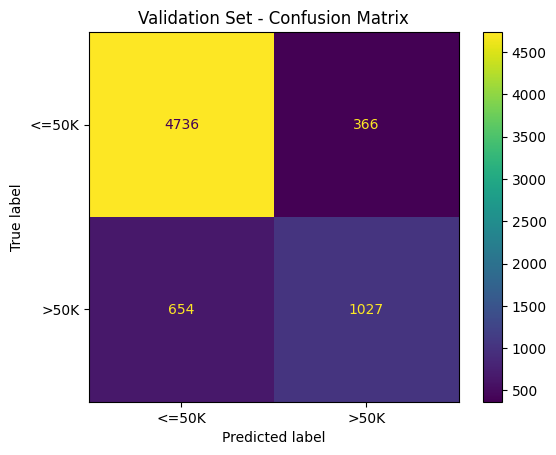

In [61]:
cm_val = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['<=50K', '>50K'])
disp.plot()
plt.title("Validation Set - Confusion Matrix")
plt.show()

Comparing this to the metrics from our Classification.ipynb notebook, conclusion is thatt performing differential privacy with Laplace noise mechanism or Randomised Response both result in very similar results.